In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from tqdm import tqdm
from functools import reduce

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [3]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

In [4]:
from utils.geometrics import haversine_distance

In [5]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [6]:
df_weather_by_day = pd.read_parquet('../data/02_intermediate/weather_by_day.parquet')
df_weather_by_day.head()

,date,temperature_2m_min,temperature_2m_max,temperature_2m,apparent_temperature,precipitation,cloud_cover,dew_point_2m,snow_depth,wind_speed_10m,wind_speed_100m,pressure_msl,relative_humidity_2m,rainfall
0,2015-01-01,-4.404,2.446,-1.819000,-7.618870,0.0,57.0,-13.166501,0.00,16.010168,26.437830,1019.634949,42.515385,0.0
1,2015-01-02,-0.654,5.296,1.206417,-4.072746,0.0,1208.0,-7.004000,0.00,15.702933,28.147974,1020.354187,54.837727,0.0
2,2015-01-03,-3.254,3.846,-0.285250,-4.296842,10.2,2343.0,-3.541500,0.02,9.848926,19.898188,1032.354126,79.118011,10.2
3,2015-01-04,4.596,13.396,8.787666,6.437127,11.1,2400.0,8.200167,0.02,13.158006,26.931124,1014.125000,96.192757,11.1
4,2015-01-05,-1.454,12.146,3.512667,-1.893868,2.4,1258.0,-4.360250,0.00,20.636959,34.627483,1015.208313,60.083797,2.4


In [7]:
df_stations = pd.read_parquet('../data/02_intermediate/stations.parquet')
df_stations.head()

,id,name,latitude,longitude,tile,latitude_tile,longitude_tile,distance_to_tile_center
0,147,'Greenwich St Warren St',40.715422,-74.011220,1,40.711147,-74.010095,0.484747
1,152,'Warren St Church St',40.714740,-74.009106,1,40.711147,-74.010095,0.408147
2,173,'Broadway W 49 St',40.760683,-73.984527,3,40.754539,-73.986911,0.712126
3,224,'Spruce St Nassau St',40.711464,-74.005524,1,40.711147,-74.010095,0.386863
4,225,'W 14 St The High Line',40.741951,-74.008030,0,40.730239,-73.998749,1.519095


In [8]:
df_bike_turnover = pd.read_parquet('../data/02_intermediate/bike_turnover.parquet')
df_bike_turnover.head()

,station_id,date_ref,n_bikes_out,n_distinct_bikes_out,n_bikes_in,n_distinct_bikes_in,turnover,turnover_distinct
0,147,2016-03-30,0.0,0.0,2.0,1.0,1.0,1.0
1,152,2017-02-23,0.0,0.0,2.0,1.0,1.0,1.0
2,152,2017-02-24,0.0,0.0,2.0,1.0,1.0,1.0
3,152,2017-02-27,0.0,0.0,2.0,1.0,1.0,1.0
4,152,2017-02-28,0.0,0.0,2.0,1.0,1.0,1.0


In [9]:
df_stations = pd.read_parquet('../data/02_intermediate/stations.parquet')
df_stations.head()

,id,name,latitude,longitude,tile,latitude_tile,longitude_tile,distance_to_tile_center
0,147,'Greenwich St Warren St',40.715422,-74.011220,1,40.711147,-74.010095,0.484747
1,152,'Warren St Church St',40.714740,-74.009106,1,40.711147,-74.010095,0.408147
2,173,'Broadway W 49 St',40.760683,-73.984527,3,40.754539,-73.986911,0.712126
3,224,'Spruce St Nassau St',40.711464,-74.005524,1,40.711147,-74.010095,0.386863
4,225,'W 14 St The High Line',40.741951,-74.008030,0,40.730239,-73.998749,1.519095


In [10]:
df_bike = pd.read_parquet('../data/01_raw/bike.parquet')
df_bike.head()

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,birth_year,gender,trip_duration_in_min
0,376,2015-10-01 00:16:26,2015-10-01 00:22:42,3212,'Christ Hospital',40.734786,-74.050444,3207,'Oakland Ave',40.737604,-74.052478,24470,Subscriber,1960.0,1,6
1,739,2015-10-01 00:27:12,2015-10-01 00:39:32,3207,'Oakland Ave',40.737604,-74.052478,3212,'Christ Hospital',40.734786,-74.050444,24481,Subscriber,1960.0,1,12
2,2714,2015-10-01 00:32:46,2015-10-01 01:18:01,3193,'Lincoln Park',40.724605,-74.078406,3193,'Lincoln Park',40.724605,-74.078406,24628,Subscriber,1983.0,1,45
3,275,2015-10-01 00:34:31,2015-10-01 00:39:06,3199,'Newport Pkwy',40.728745,-74.032108,3187,'Warren St',40.721124,-74.038051,24613,Subscriber,1975.0,1,5
4,561,2015-10-01 00:40:12,2015-10-01 00:49:33,3183,'Exchange Place',40.716247,-74.033459,3192,'Liberty Light Rail',40.711242,-74.055701,24668,Customer,1984.0,0,9


In [23]:
# spine is defined as 

def build_spine(df_bike):
    df_out = (
        df_bike
        .rename(columns={'start_station_id': 'station_id'})
        .groupby('station_id')
        .agg(
            start_time=('start_time', 'min'),
            stop_time=('stop_time', 'max'),
        )
    )
    df_in = (
        df_bike
        .rename(columns={'end_station_id': 'station_id'})
        .groupby('station_id')
        .agg(
            start_time=('start_time', 'min'),
            stop_time=('stop_time', 'max'),
        )
    )
    df_spine = (
        pd.concat([df_out, df_in], axis=0)
        .reset_index()
        .groupby('station_id')
        .agg(
            start_time=('start_time', 'min'),
            stop_time=('stop_time', 'max'),
        )
    )
    df_spine['date_ref'] = df_spine.apply(lambda x: pd.date_range(start=x['start_time'], end=x['stop_time'], freq='D').tolist(), axis=1)
    df_spine = (
        df_spine
        .explode('date_ref')
        .eval('date_ref = date_ref.dt.date')
        [['date_ref']]
        .reset_index()
    )

    return df_spine
    

df_spine = build_spine(df_bike)
df_spine.head()

,station_id,date_ref
0,147,2016-03-30
1,152,2017-02-23
2,152,2017-02-24
3,152,2017-02-25
4,152,2017-02-26


/var/folders/wc/m7rw72k9145cvlh3g5j2n3zr0000gn/T/ipykernel_64668/4021102848.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index='date_ref', columns=var, values='bike_id', aggfunc='count')
/var/folders/wc/m7rw72k9145cvlh3g5j2n3zr0000gn/T/ipykernel_64668/4021102848.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index='date_ref', columns=var, values='bike_id', aggfunc='count')


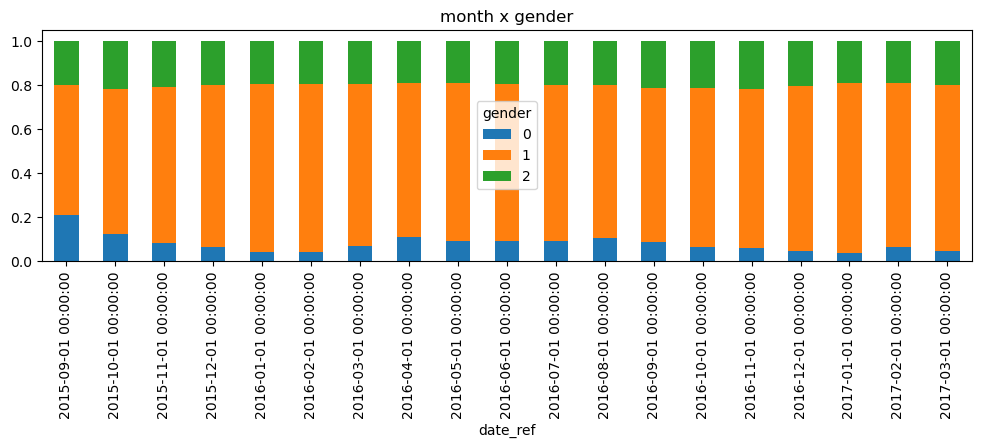

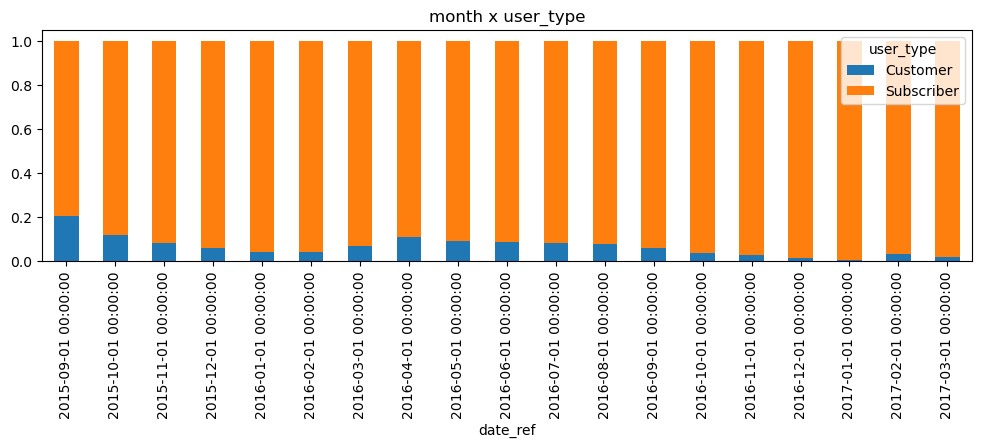

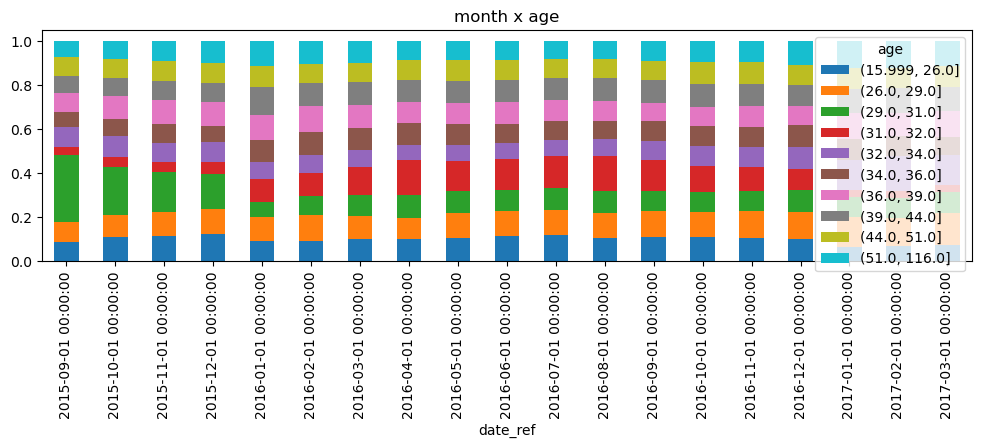

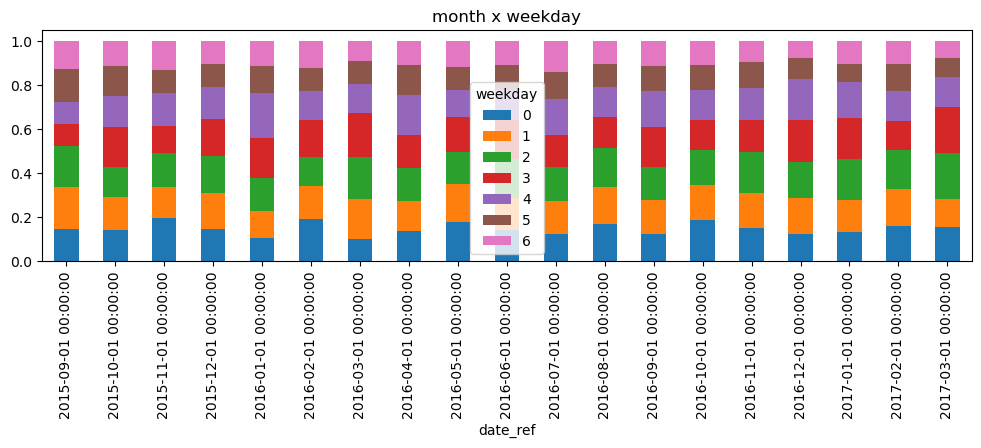

In [24]:
def eda(df_bike):
    df_bike = (
         df_bike
        .assign(
            week_id = lambda x: x['start_time'].dt.to_period('W').dt.to_timestamp(how='start'),
            date_ref = lambda x: x['start_time'].dt.to_period('M').dt.to_timestamp(how='start'),
        )
        .eval('weekday = start_time.dt.dayofweek')
        .eval('age = date_ref.dt.year - birth_year')
        .assign(age=lambda x:pd.qcut(x['age'],10))
    )
    for var in ['gender','user_type','age','weekday']:
        df = (
            df_bike
            .pivot_table(index='date_ref', columns=var, values='bike_id', aggfunc='count')
        )
        df.div(df.sum(axis=1), axis=0).plot(kind='bar',stacked=True, figsize=(12,3), title='month x {}'.format(var))
eda(df_bike)

In [25]:
class FPercentile:
    def __init__(self, percentile):
        self.percentile = percentile

    def __call__(self, s):
        return np.percentile(s, 99)

    def __str__(self):
        return f"p{self.percentile}"

fp99 = FPercentile(99)
fp05 = FPercentile(5)

In [36]:
feature_engineering_dict = {
    'duration':['mean','min','sum'],
    'distance':['mean','median',fp05,fp99],
    'gender':['mean'],
    'isSubscriber':['mean'],
    'loopback':['mean'],
    'age_00_24':['mean'],
    'age_25_34':['mean'],
    'age_35_44':['mean'],
    'age_45_00':['mean'],
    'age':['mean','median',fp05,fp99],
}

################################
# This is the spine with features
################################

df_station_day_level = (
    df_bike
    .assign(
        week_id = lambda x: x['start_time'].dt.to_period('W').dt.to_timestamp(how='start'),
        date_ref = lambda x: x['start_time'].dt.to_period('D').dt.to_timestamp(how='start'),
    )
    # basic feature engineering at hide level
    .eval('distance = @haversine_distance(start_station_latitude, start_station_longitude, end_station_latitude, end_station_longitude)')
    .eval('gender = gender==1')
    .eval('loopback = start_station_id == end_station_id')
    .eval('isSubscriber = user_type=="Subscriber"')
    .eval('age = date_ref.dt.year - birth_year')
    .eval('age_00_24 = age <= 24')
    .eval('age_25_34 = age > 24 and age <= 34')
    .eval('age_35_44 = age > 34 and age <= 44')
    .eval('age_45_00 = age > 44')
    .rename(columns={'trip_duration_in_min':'duration'})

    # aggreating on day and start_station level
    .groupby(['start_station_id','date_ref'])
    .agg(
        **{'n_rents':('bike_id','size'),},
        **{
            f'{v}_{func}':(v,func)
                for v in feature_engineering_dict.keys()
                for func in feature_engineering_dict[v]
        }
    )
    .reset_index()
    .eval('weekday = date_ref.dt.weekday')
    .eval('month = date_ref.dt.month')
    .eval('date_ref = date_ref.dt.date')
    .rename(columns={
        'isSubscriber_mean':'subscriber_rate',
        'gender_mean':'gender_rate',
        'start_station_id':'station_id',
    })
)

In [37]:
df_station_day_level.head().T

,0,1,2,3,4
station_id,3183,3183,3183,3183,3183
date_ref,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25
n_rents,29,64,60,51,46
duration_mean,12.034483,9.84375,12.85,9.196078,11.652174
duration_min,2,2,2,2,2
duration_sum,349,630,771,469,536
distance_mean,1.045365,1.287667,1.095387,1.008318,1.111958
distance_median,0.890791,1.229751,0.894698,0.666205,1.224425
distance_p5,3.563407,3.984896,3.820818,3.320056,3.320056
distance_p99,3.563407,3.984896,3.820818,3.320056,3.320056


In [41]:
df_master_table = (
    df_station_day_level
    .merge(
        df_spine,
        on=['station_id', 'date_ref'],
        how='left'
    )
    .merge(
        df_stations[['id','tile','distance_to_tile_center']]
        .rename(columns={'id':'station_id'})
        .astype({'tile':'str'}),
        on='station_id'
    )
    .merge(
        df_weather_by_day
        .rename(columns={'date':'date_ref'})
        .eval('date_ref = date_ref.dt.date'),
        on='date_ref'
    )
)

In [45]:
def window_feature(df, cols, metrics=['mean','sum'], add_trend=True, window=[1,2,3,7,15,30,60,90]):
    """
    Create a window feature for the given column in the dataframe.
    """

    for col in cols:
        for m in metrics:
            for w in window:
                df[f'{col}_{m}_w{w}'] = df[col].ffill().shift(w).agg(m)

            if add_trend:
                cols = [f'{col}_{m}_w{w}' for w in window]
                df[f'{col}_{m}_trend'] = df[cols].apply(lambda x: np.polyfit(window, x, 1)[0], axis=1)

    return df

In [46]:
var_for_window =[
    'n_rents',
    'duration_mean',
    'duration_sum',
    'distance_mean',
    'distance_median',
    'distance_p5',
    'distance_p99',
    'gender_rate',
    'subscriber_rate',
    'loopback_mean',
    'age_00_24_mean',
    'age_25_34_mean',
    'age_35_44_mean',
    'age_45_00_mean',
    'age_mean',
    'age_median',
    'temperature_2m_min',
    'temperature_2m_max', 
    'temperature_2m',
    'apparent_temperature',
    'precipitation', 
    'cloud_cover', 
    'dew_point_2m',
    'snow_depth',
    'wind_speed_10m',
    'wind_speed_100m',
    'pressure_msl',
    'relative_humidity_2m',
    'rainfall',
    ]
df_master_table_with_window = (
    df_master_table
    .sort_values(['station_id','date_ref'])
    .groupby('station_id')
    .apply(
        window_feature,
        cols=var_for_window
    )
    .reset_index(drop=True)
)

/var/folders/wc/m7rw72k9145cvlh3g5j2n3zr0000gn/T/ipykernel_64668/1526520460.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  .apply(
/var/folders/wc/m7rw72k9145cvlh3g5j2n3zr0000gn/T/ipykernel_64668/1526520460.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [49]:
def build_target(df):
    df = df.sort_values('date_ref')
    df['target_bruto'] = df['n_rents'].shift(-1)/df['n_rents']
    df['target'] = (df['target_bruto']> 1.2).astype(int)
    return df

df_master_table_with_window = (
    df_master_table_with_window
    .groupby('station_id', group_keys=False)
    .apply(build_target)
)

/var/folders/wc/m7rw72k9145cvlh3g5j2n3zr0000gn/T/ipykernel_64668/3368293989.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(build_target)


In [50]:
df_master_table_with_window

,station_id,date_ref,n_rents,duration_mean,duration_min,duration_sum,distance_mean,distance_median,distance_p5,distance_p99,...,rainfall_sum_w2,rainfall_sum_w3,rainfall_sum_w7,rainfall_sum_w15,rainfall_sum_w30,rainfall_sum_w60,rainfall_sum_w90,rainfall_sum_trend,target_bruto,target
0,3183,2015-09-21,29,12.034483,2,349,1.045365,0.890791,3.563407,3.563407,...,1251.800049,1247.400024,1227.699951,1225.199951,1195.599976,1179.0,1077.400024,-1.739291,2.206897,1
1,3183,2015-09-22,64,9.843750,2,630,1.287667,1.229751,3.984896,3.984896,...,1251.800049,1247.400024,1227.699951,1225.199951,1195.599976,1179.0,1077.400024,-1.739291,0.937500,0
2,3183,2015-09-23,60,12.850000,2,771,1.095387,0.894698,3.820818,3.820818,...,1251.800049,1247.400024,1227.699951,1225.199951,1195.599976,1179.0,1077.400024,-1.739291,0.850000,0
3,3183,2015-09-24,51,9.196078,2,469,1.008318,0.666205,3.320056,3.320056,...,1251.800049,1247.400024,1227.699951,1225.199951,1195.599976,1179.0,1077.400024,-1.739291,0.901961,0
4,3183,2015-09-25,46,11.652174,2,536,1.111958,1.224425,3.320056,3.320056,...,1251.800049,1247.400024,1227.699951,1225.199951,1195.599976,1179.0,1077.400024,-1.739291,1.282609,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19964,3281,2017-03-28,4,21.000000,21,84,4.079638,4.079638,4.079638,4.079638,...,377.200012,372.800049,353.100006,342.099976,321.099976,282.5,225.800003,-1.629492,2.000000,1
19965,3281,2017-03-29,8,14.500000,9,116,2.915941,2.915941,4.058342,4.058342,...,377.200012,372.800049,353.100006,342.099976,321.099976,282.5,225.800003,-1.629492,1.500000,1
19966,3281,2017-03-30,12,14.333333,9,172,2.398682,1.773539,4.058342,4.058342,...,377.200012,372.800049,353.100006,342.099976,321.099976,282.5,225.800003,-1.629492,0.333333,0
19967,3281,2017-03-31,4,11.000000,11,44,1.773539,1.773539,1.773539,1.773539,...,377.200012,372.800049,353.100006,342.099976,321.099976,282.5,225.800003,-1.629492,NaN,0


array([<Axes: xlabel='date_ref'>, <Axes: xlabel='date_ref'>], dtype=object)

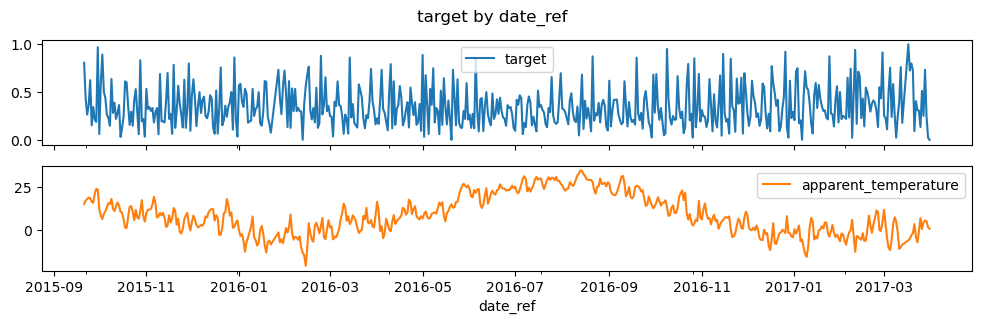

In [56]:
(
    df_master_table_with_window
    .groupby('date_ref')
    .agg(target=('target', 'mean'),apparent_temperature=('apparent_temperature', 'mean'))
    .plot(figsize=(12, 3), title='target by date_ref',subplots=True)
)

array([<Axes: xlabel='apparent_temperature', ylabel='target'>],
      dtype=object)

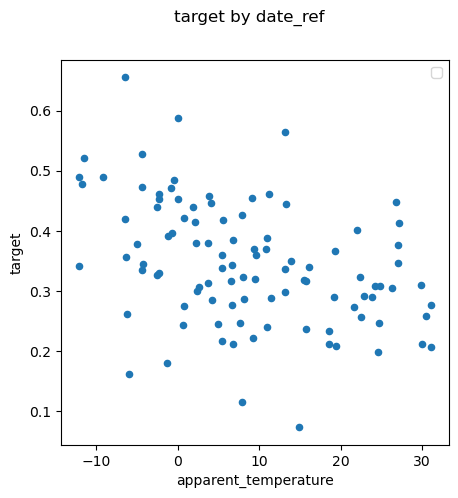

In [75]:
ceil = np.ceil
rand = np.random.rand
(
    df_master_table_with_window
    .groupby('date_ref')
    .agg(target=('target', 'mean'),apparent_temperature=('apparent_temperature', 'mean'))
    .eval('rtemp  = @ceil(apparent_temperature.rank(pct=True)*20)')
    .eval('rdg  = @ceil(@rand(apparent_temperature.shape[0])*5)')
    .groupby(['rtemp','rdg'])
    .agg(target=('target', 'mean'),apparent_temperature=('apparent_temperature', 'mean'))
    .plot(figsize=(5, 5),x='apparent_temperature', y='target', kind='scatter', title='target by date_ref',subplots=True)
)

In [76]:
(
    df_master_table_with_window.isna()
    .groupby(df_master_table_with_window['date_ref'].dt.strftime('%Y%m'))
    .mean()
    .assign(max_missing=lambda x: x.max(axis=1))
    .query('max_missing > 0')
    .T
    .assign(max_missing=lambda x: x.max(axis=1))
    .query('max_missing > 0')
    .drop(columns=['max_missing'])
    .T
    # .sort_values('nmiss', ascending=False)
)

AttributeError: Can only use .dt accessor with datetimelike values

In [78]:
df_master_table_with_window.to_parquet('../data/02_intermediate/master_table.parquet', index=False)